### **HUMAN ACTIVITY DETECTION USING SMARTPHONE SENSORS**
### **PROJECT BY ~ ALAISSA SHAIKH**


---

**The objective of this project is to develop a human activity recognition (HAR) model using Spiking Neural Networks (SNNs) and Random Forest Classifier to classify and predict human activities based on sensor data accurately.**

---

**Key Objectives**

Explore Spiking Neural Networks for Temporal Data

Process and Analyze Sensor Data

Classify Human Activities

Evaluate Model Performance

Implement an Energy-Efficient Solution

---


In [ ]:
!pip install norse torch joblib

In [1]:
import warnings
warnings.filterwarnings('ignore')

**Importing Necessary Libraries**

In [3]:
import numpy as np
import pandas as pd
import torch
import norse
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import zipfile
import os
import joblib

**Understanding and Handling Data**

In [ ]:
zip_path = "archive (8).zip"  
extract_path = "Desktop/DESPU/human_activity_sensors"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Defining labels and signals
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
SIGNALS = ["body_acc_x_", "body_acc_y_", "body_acc_z_", "body_gyro_x_", "body_gyro_y_", "body_gyro_z_", "total_acc_x_", "total_acc_y_", "total_acc_z_"]

In [7]:
data_path = "Desktop/DESPU/human_activity_sensors/UCI HAR Dataset/"

# Setting paths for training and testing signal data
train_signals_path = os.path.join(data_path, "train/Inertial Signals/")
test_signals_path = os.path.join(data_path, "test/Inertial Signals/")
train_labels_path = os.path.join(data_path, "train/y_train.txt")
test_labels_path = os.path.join(data_path, "test/y_test.txt")

In [9]:
# Defining file paths for training and testing signals
train_paths = [train_signals_path + signal + 'train.txt' for signal in SIGNALS]
test_paths = [test_signals_path + signal + 'test.txt' for signal in SIGNALS]

In [11]:
# Loading signal data
def load_signals(signal_paths):
    signals = []
    for signal_file in signal_paths:
        with open(signal_file, 'r') as file:
            signals.append(
                [np.array(series, dtype=np.float32) for series in [
                    row.replace('  ', ' ').strip().split(' ') for row in file
                ]]
            )
    return np.transpose(np.array(signals), (1, 2, 0))

In [13]:
# loading training and testing data
x_train = load_signals(train_paths)
x_test = load_signals(test_paths)
y_train = np.loadtxt(train_labels_path, dtype=np.int32) - 1  # Class labels (0-indexed)
y_test = np.loadtxt(test_labels_path, dtype=np.int32) - 1

In [15]:
print("Shape of x_train:", x_train.shape)  
print("Shape of y_train:", y_train.shape)  
print("First 10 activity labels:", [LABELS[label] for label in y_train[:10]])

Shape of x_train: (7352, 128, 9)
Shape of y_train: (7352,)
First 10 activity labels: ['STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING']


In [17]:
%matplotlib inline

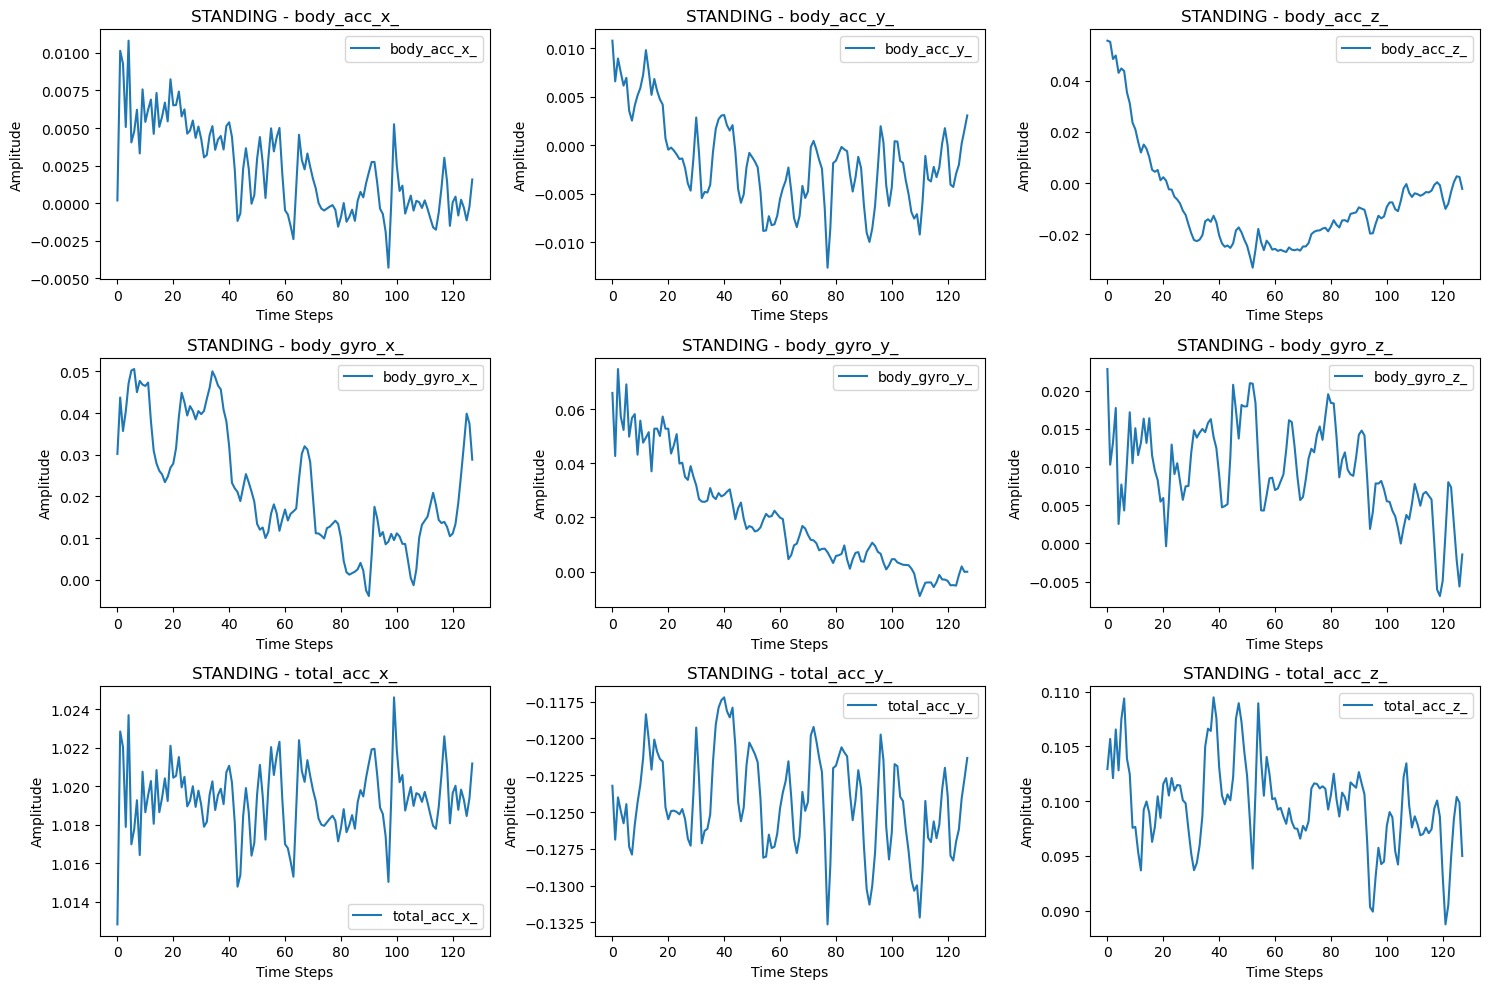

In [19]:
activity_label = "STANDING"  
signals = x_train[0]  
signal_names = SIGNALS  

# Plotting each signal for the selected activity
plt.figure(figsize=(15, 10))
time_steps = np.arange(128) 

for i, signal_name in enumerate(signal_names):
    plt.subplot(3, 3, i + 1)
    plt.plot(time_steps, signals[:, i], label=signal_name)  
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.title(f"{activity_label} - {signal_name}")
    plt.legend()

plt.tight_layout()
plt.show()

#### Each plot shows how the signal amplitude changes over 128-time steps, visually representing the sensor data for this specific sample and activity.
---

**Defining SNN Model and Further Model Handling**

In [21]:
# Defining the SNN Encoder Model
class SNNEncoder(nn.Module): #base class for all neural network modules in PyTorch
    def __init__(self, input_dim, hidden_dim):
        super(SNNEncoder, self).__init__()
        self.snn_layer1 = norse.torch.LIFCell()
        self.linear = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        s1 = torch.zeros(x.size(0), 128, x.size(2))
        lif_state = None
        for ts in range(x.size(1)):
            lif_out, lif_state = self.snn_layer1(x[:, ts, :], lif_state)
            s1[:, ts, :] = lif_out
        encoded = self.linear(s1.mean(dim=1))
        return encoded

In [23]:
# Initializing the encoder model
input_dim = x_train.shape[2]
hidden_dim = 50
encoder = SNNEncoder(input_dim, hidden_dim)

In [25]:
# Encoding Data with SNN
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

In [27]:
# Encoding the training and testing data
X_train_encoded = encoder(x_train_tensor).detach().numpy()
X_test_encoded = encoder(x_test_tensor).detach().numpy()

In [29]:
# Training a Random Forest Classifier
def train_rf(x_train, y_train, n_estimators=300):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    rf_model.fit(x_train, y_train)
    return rf_model

rf_model = train_rf(X_train_encoded, y_train)
train_acc = accuracy_score(y_train, rf_model.predict(X_train_encoded))
test_acc = accuracy_score(y_test, rf_model.predict(X_test_encoded))

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training accuracy: 0.8838411316648531
Testing accuracy: 0.7102137767220903


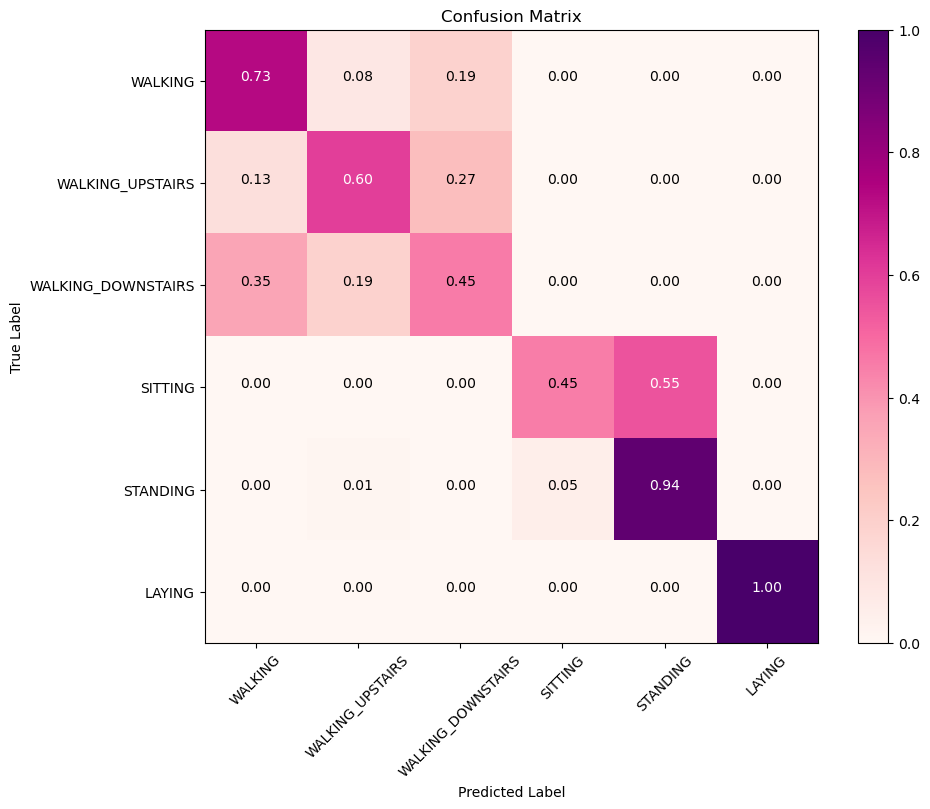

In [90]:
# Plotting Confusion Matrix
def plot_confusion_matrix(model, X, y, class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.RdPu):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Using the updated function with a pinkish colormap
plot_confusion_matrix(rf_model, X_test_encoded, y_test, class_names=LABELS, normalize=True)

**Model Saving - Loading - Testing**

In [33]:
# Saving the Models
joblib.dump(rf_model, "random_forest_model.pkl")
torch.save(encoder.state_dict(), "snn_encoder_model.pth")

In [35]:
# Loading and Testing the Models
def load_models():
    rf_model = joblib.load("random_forest_model.pkl")
    encoder = SNNEncoder(input_dim, hidden_dim)
    encoder.load_state_dict(torch.load("snn_encoder_model.pth"))
    return encoder, rf_model

def test_model(x_data, encoder, rf_model):
    x_data_tensor = torch.tensor(x_data, dtype=torch.float32)
    x_data_encoded = encoder(x_data_tensor).detach().numpy()
    predictions = rf_model.predict(x_data_encoded)
    return predictions

In [47]:
# Testing with a few examples
encoder_loaded, rf_model_loaded = load_models()
sample_predictions = test_model(x_test[80:90], encoder_loaded, rf_model_loaded)
print("Sample predictions:", [LABELS[pred] for pred in sample_predictions])

Sample predictions: ['WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING', 'WALKING']


In [102]:
# Testing Model
sample_indices = range(80, 90) 
sample_predictions = test_model(x_test[sample_indices], encoder_loaded, rf_model_loaded)

In [71]:
# Prepare a list to hold data for each row in the DataFrame
data = []

In [79]:
# Gather detailed sensor data and predictions for each sample
for idx, i in enumerate(sample_indices):
    sample_data = {"Sample Index": i, "Predicted Activity": LABELS[sample_predictions[idx]]}
    
    # Add sensor values for the first few time steps to the data (for each sensor)
    for j, signal_name in enumerate(SIGNALS):
        # Aggregating data for better display; using mean and standard deviation over the time steps
        sample_data[f"{signal_name}_mean"] = x_test[i][:, j].mean()
        sample_data[f"{signal_name}_std"] = x_test[i][:, j].std()

        sample_data[f"{signal_name}_first_5"] = x_test[i][:5, j].tolist()
    
    # Append the sample data to the overall data list
    data.append(sample_data)

# Create the DataFrame
df = pd.DataFrame(data)

In [75]:
# Display the DataFrame
df_display_name = "Human Activity Detection - Detailed Sensor Data and Predictions"
print(f"\n{df_display_name}")
display(df)


Human Activity Detection - Detailed Sensor Data and Predictions


,Sample Index,Predicted Activity,body_acc_x__mean,body_acc_x__std,body_acc_x__first_5,body_acc_y__mean,body_acc_y__std,body_acc_y__first_5,body_acc_z__mean,body_acc_z__std,...,body_gyro_z__first_5,total_acc_x__mean,total_acc_x__std,total_acc_x__first_5,total_acc_y__mean,total_acc_y__std,total_acc_y__first_5,total_acc_z__mean,total_acc_z__std,total_acc_z__first_5
0,80,WALKING,-0.005818,0.195761,"[0.16390429437160492, 0.08020766824483871, -0....",0.007200,0.148432,"[0.07091917097568512, 0.0465925894677639, 0.04...",0.017266,0.099518,...,"[0.2937876880168915, 0.2942194938659668, 0.190...",0.975699,0.194992,"[1.1535459756851196, 1.0696640014648438, 0.898...",-0.326038,0.148243,"[-0.2497158944606781, -0.2744660973548889, -0....",0.036280,0.099294,"[-0.08494610339403152, -0.07901327311992645, -..."
1,81,WALKING,0.009784,0.174517,"[-0.2697547972202301, -0.13592979311943054, -0...",-0.006643,0.174177,"[0.11410540342330933, 0.13481269776821136, 0.0...",0.010062,0.116290,...,"[0.27010470628738403, 0.22033320367336273, 0.0...",0.996712,0.174181,"[0.7064660787582397, 0.8405809998512268, 0.949...",-0.340214,0.173977,"[-0.2238589972257614, -0.20289720594882965, -0...",0.034116,0.114802,"[0.1136614978313446, 0.14187310636043549, 0.15..."
2,82,WALKING,0.006436,0.158430,"[0.21687479317188263, 0.03674048185348511, 0.2...",-0.002617,0.177335,"[0.31478309631347656, 0.3787569999694824, 0.01...",-0.007861,0.119629,...,"[-0.12213379889726639, 0.11925110220909119, 0....",0.996218,0.157904,"[1.2061660289764404, 1.026039958000183, 1.1926...",-0.336500,0.176868,"[-0.01594436913728714, 0.047947779297828674, -...",0.012969,0.118303,"[0.2721624970436096, 0.14748430252075195, 0.07..."
3,83,WALKING,-0.002468,0.162921,"[-0.07347980886697769, -0.1737505942583084, -0...",0.000630,0.144113,"[0.04643569886684418, 0.12904630601406097, 0.0...",-0.004110,0.112388,...,"[-0.10916530340909958, -0.006902667228132486, ...",0.987944,0.162287,"[0.918897807598114, 0.8184648752212524, 0.9653...",-0.328862,0.143300,"[-0.289330393075943, -0.2066453993320465, -0.3...",0.011822,0.111437,"[-0.0881117731332779, -0.19893699884414673, -0..."
4,84,WALKING,-0.018580,0.179134,"[-0.1472076028585434, -0.24246789515018463, -0...",0.002940,0.138484,"[-0.13398270308971405, -0.10635189712047577, -...",0.000594,0.099769,...,"[-0.01427851989865303, -0.09993225336074829, -...",0.975098,0.179243,"[0.8408793210983276, 0.7459148168563843, 0.778...",-0.325499,0.137841,"[-0.4618108868598938, -0.4342342019081116, -0....",0.019575,0.099343,"[0.046368859708309174, 0.0587838813662529, -0...."
5,85,WALKING,0.001366,0.189565,"[-0.13524509966373444, -0.16054129600524902, -...",0.016177,0.136570,"[0.10444170236587524, 0.0838613212108612, 0.11...",-0.001865,0.095970,...,"[0.06268995255231857, 0.053015779703855515, 0....",0.987349,0.188852,"[0.8649985790252686, 0.8398033976554871, 0.908...",-0.316485,0.136633,"[-0.22091029584407806, -0.24182190001010895, -...",0.019658,0.095595,"[-0.08075007796287537, -0.030979879200458527, ..."
6,86,WALKING,0.016539,0.178627,"[0.07214631885290146, 0.08534996956586838, 0.1...",0.001898,0.146398,"[0.05744205042719841, 0.05888424068689346, 0.1...",-0.007586,0.110198,...,"[0.31269198656082153, 0.09793224930763245, -0....",1.001162,0.178199,"[1.052690029144287, 1.0652530193328857, 1.0838...",-0.327266,0.146246,"[-0.281545490026474, -0.2802942991256714, -0.2...",0.011196,0.109517,"[-0.02911408059298992, -0.013221190311014652, ..."
7,87,WALKING_DOWNSTAIRS,0.008477,0.167834,"[0.2345868945121765, 0.12182539701461792, -0.0...",-0.010751,0.151964,"[-0.06646125763654709, -0.25183218717575073, -...",-0.007965,0.114087,...,"[-0.35445278882980347, -0.5519940257072449, -0...",0.998995,0.167231,"[1.2179100513458252, 1.1052989959716797, 0.957...",-0.333461,0.152071,"[-0.39550039172172546, -0.5804287791252136, -0...",0.009692,0.112960,"[-0.13054589927196503, -0.23171299695968628, -..."
8,88,WALKING,0.008760,0.160415,"[0.21424350142478943, 0.28466689586639404, 0.1...",0.003304,0.147343,"[-0.217